## Import libs and data

In [1]:
import pandas as pd
import re
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()
import pickle
import datetime
from tqdm import tqdm_notebook

In [2]:
df_post = pd.read_csv('../out/aviation/df_post.csv')

In [3]:
with open('../out/aviation/tokens_post.txt', 'rb') as fp:   #Pickling
    tokens_post = pickle.load(fp)

## Calculate sentiment score and clean

In [4]:
pos_txt = list(pd.read_csv('../src/positive-sentiment-words.txt',header=None)[0].values)
neg_txt = list(pd.read_csv('../src/negative-sentiment-words.txt', header=None)[0].values)

In [5]:
print('total pos word: ',len(pos_txt))
print('total neg word: ',len(neg_txt))

total pos word:  512
total neg word:  1218


In [6]:
pos_score_list = []
neg_score_list = []
for w_list in tqdm_notebook(tokens_post):
    pos_score=0
    neg_score=0
    for w in w_list:
        if w in pos_txt:pos_score+=1
        if w in neg_txt:neg_score+=1
    pos_score_list.append(pos_score)
    neg_score_list.append(neg_score)
    
df_post['pos_score'] = pos_score_list
df_post['neg_score'] = neg_score_list
df_post['sent_score'] = df_post.pos_score - df_post.neg_score

In [7]:
df_post['sent_score'].describe()

count    54844.000000
mean         0.461454
std          3.012587
min        -50.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         46.000000
Name: sent_score, dtype: float64

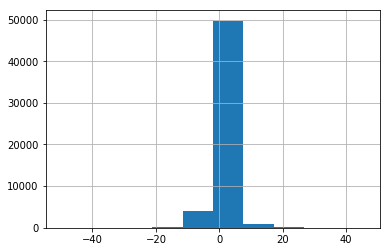

In [8]:
_ = df_post.sent_score.hist()

In [9]:
df_post['sentiment'] = df_post.sent_score.apply(lambda x:'positive' if x>0 else 'negative' if x<0 else 'neutral')

In [10]:
df_post['post_date'] = pd.to_datetime(df_post['post_date'])

## Input to program
1) Key words<br>
2) As of date<br>
3) Window length<br>

In [13]:
# IDEA: -> add useful statistic like lift for keywords co-occurence
# analyse keyword x tags
# use word vector to explore neighbor words

## Base sentiment query

Total posts: 1722
Total mentions: 203 



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  app.launch_new_instance()


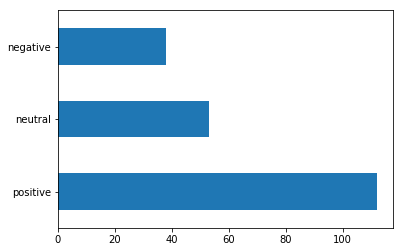

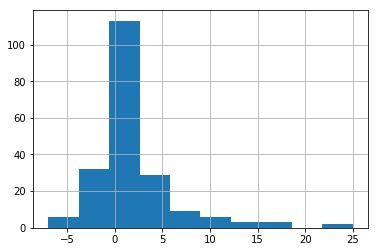

sentiment score:25
กระทู้ชื่นชมอาหารการบินไทย วันนี้อร่อยมาก ทั้งไปและกลับ เนื่องจากช่วงที่ผ่านมาสองสามเดือน เรารู้สึกว่าอาหารการบินไทย จืดลงไปมาก เน้นผักบ้าง บางทีมาแต่โปรตีนก็ไม่มีผักแก้เลี่ยนเลย ขนมก็ไม่ค่อยโดนใจเหมือนเก่า ไปดูที่เล้าจน์ ขาออกเชียงใหม่ไม่ต้องพูดถึงเพราะปรับปรุง ได้ไปทานอาหารจานเดียวในครัวการบินไทยแทน แต่เล้าจน์ที่สุวรรณภูมิ แม้ว่าจะปรับเปลี่ยนอาหารเพิ่มมากขึ้นหลายอย่าง แต่ก็ไม่ถูกปาก ทั้งข้าวมันไก่ที่ไม่นุ่ม หมูสะเต๊ะที่ค่อนข้างแข็ง และอื่น รวมไปถึงอาหารบนเครื่องจืด และเมนูน่าเบื่อ แต่...วันนี้เราเดินทางจาก เชียงใหม่ไป สุวรรณภูมิ เที่ยวบิน TG111 เครื่องออก 15.10 ถึง กรุงเทพ 16.20อาหารขาไป เป็นบะหมี่ไก่ อร่อยมาก บะหมี่นุ่ม ร้อน กำลังพอดี ไก่นุ่มมาก ไม่เจอชิ้นแข็งเลย ปรุงรสได้ดี กินหมดเกลี้ยงเลย ขนมเป็นพานาค้อทต้า ไม่แน่ใจว่ามะม่วงมั้ยสีเหลืองด้านล่าง ใจชอบคิดว่าเป็นฟักทองแต่มันอมเปรี้ยว คิดว่าน่าจะมะม่วง คือรสผลไม้ไม่เด่น เพราะราดหน้าด้วยซอสสตอเบอรี่เข้มข้น อร่อยเข้ากันมากๆ ช่วงหลังๆ ขนมไม่ดึงดูดเลย แต่วันนี้อร่อยดีขากลับ เรากลับไฟลท์ TG 120 เครื่องออก 18.40 ถึงเชียง

In [11]:
kws = ['การบินไทย','tg']
dt = datetime.date(2018,11,1)
win_len = 365

idxs=[]
for i,tkn in enumerate(tokens_post):
    for kw in kws:
        if kw in tkn:
            idxs.append(i)
            break

df_temp = df_post.copy()
df_temp = df_temp.iloc[idxs]
print('Total posts:',len(df_temp))
# filter by datetime
df_temp = df_temp.loc[(df_temp.post_date < dt)&\
                      (dt - df_temp.post_date.dt.date < datetime.timedelta(days=win_len))]
print('Total mentions:',len(df_temp),'\n')
_=df_temp.sentiment.value_counts().plot('barh')
plt.show()
_=df_temp['sent_score'].hist()
plt.show()
# show top 5 positive and negative posts
for row in df_temp.sort_values('sent_score',ascending=False).head(5)[['title-content','sent_score']].iterrows():
    print('sentiment score:' + str(row[1]['sent_score'] )+ '\n' + row[1]['title-content']+'\n')

print('##############################################################################################################')

for row in df_temp.sort_values('sent_score',ascending=True).head(5)[['title-content','sent_score']].iterrows():
    print('sentiment score:' + str(row[1]['sent_score'] )+ '\n' + row[1]['title-content']+'\n')

## Visualize sentiment through time

In [12]:
# extract month-year and year from date time
df_post['month-year'] = df_post.post_date.progress_apply(lambda x:datetime.date(x.year,x.month,1))

100%|██████████| 54844/54844 [00:00<00:00, 114075.65it/s]


In [13]:
df_post['year'] = df_post.post_date.dt.year

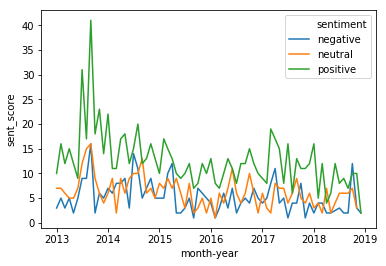

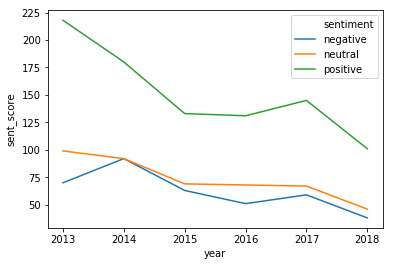

In [14]:
kws = ['การบินไทย','tg']

idxs=[]
for i,tkn in enumerate(tokens_post):
    for kw in kws:
        if kw in tkn:
            idxs.append(i)
            break

# copy and filter
df_temp = df_post.copy()
df_temp = df_temp.iloc[idxs]

# aggregate
df_temp_mo = df_temp.groupby(['month-year','sentiment'])['sent_score'].count().reset_index()
df_temp_y = df_temp.groupby(['year','sentiment'])['sent_score'].count().reset_index()

_ = sns.lineplot(x='month-year', y='sent_score', hue='sentiment',data=df_temp_mo)
plt.show()
_ = sns.lineplot(x='year', y='sent_score', hue='sentiment',data=df_temp_y)
plt.show()

## sentiment by user

In [15]:
kws = ['การบินไทย','tg']
dt = datetime.date(2018,12,1)
win_len = 365

idxs=[]
for i,tkn in enumerate(tokens_post):
    for kw in kws:
        if kw in tkn:
            idxs.append(i)
            break

df_temp = df_post.copy()
df_temp = df_temp.iloc[idxs]
print('Total posts: ',len(df_temp))
# filter by datetime
df_temp = df_temp.loc[(df_temp.post_date < dt)&\
                      (dt - df_temp.post_date.dt.date < datetime.timedelta(days=win_len))]
print('Total mentions: ',len(df_temp))

print('Total unique user: ',df_temp.user_id.nunique())

Total posts:  1722
Total mentions:  202
Total unique user:  173


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  app.launch_new_instance()


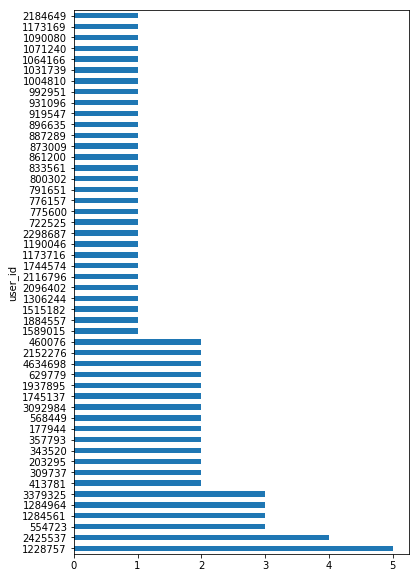

In [17]:
df_temp['user_id'] = df_temp['user_id'].astype(int)

# visualize engagement by top user
df_temp_user = df_temp.groupby('user_id')['sentiment'].count().reset_index().sort_values('sentiment',ascending=False)

df_temp_user.rename({'sentiment':'total_post'},axis=1,inplace=True)

_ = df_temp_user.head(50).plot(x='user_id',y='total_post',kind='barh',legend=False,figsize=(6,10))

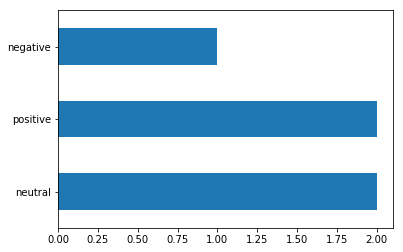

In [18]:
# single user view
user_id = 1228757
df_temp_1u = df_temp.loc[df_temp.user_id == user_id]

_ = df_temp_1u.sentiment.value_counts().plot('barh')